In [15]:
from netCDF4 import Dataset
from pathlib import Path

import datetime

import numpy  as np
import pandas as pd
import xarray as xr

from pylab import *

import matplotlib.pyplot     as plt
import matplotlib.cm         as cm
import matplotlib.colors     as mcolors
import matplotlib.patches    as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.dates      as mdates

from   matplotlib.pyplot     import figure, show

import pywt 

import scipy.io        as scio
import scipy.constants as const

from   scipy.fftpack   import fft
from   scipy.stats     import chi2

In [2]:
def FFT(Fs, data):
    L = len(data)

    N = np.power(2, np.ceil(np.log2(L)))
    N = int(N)

    FFT_y = np.abs(fft(data,N))/L*2
    Fre   = np.arange(int(N/2))*Fs/N
    FFT_y = FFT_y[range(int(N/2))]
    
    return Fre, FFT_y

# 计算lags阶以内的自相关系数，返回lags个值，将序列均值、标准差视为不变
def autocorrelation(x,lags):
    n = len(x)
    x = np.array(x)
    variance = x.var()
    x = x-x.mean()
    result = np.correlate(x, x, mode = 'full')[-n+1:-n+lags+1]/\
    (variance*(np.arange(n-1,n-1-lags,-1)))
    return result

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

def format_func(x, pos=None):
    x = mdates.num2date(x)
    if x.hour%8 == 0 :
        fmt = '%H\n%y/%m/%d'
    else:
        fmt = '%H'
    label = x.strftime(fmt)
    
    return label

# period = 86400    # test
def plot_TECs_at_station(sTEC,
                         zeniths,
                         time_system = 'UTC'
                        ):
    ax = figure().gca()
    
    colors = ['orangered',
#               'crimson',
              'gold', 
              'aquamarine', 
#               'mediumaquamarine',
              'dodgerblue',
              'greenyellow',
#               'darkviolet'
             ]
    
    eleDegrees = 90 - np.degrees(zeniths)
    
    for i, sv in enumerate(sTEC.sv):
        ax.plot(sTEC.time.values[::10], 
                sTEC.sel(sv = sv)[::10],
                color = colors[i],
#                 marker = ',',
                linestyle = "-", 
                linewidth = '0.8',
                label = f'{sv.values} ' 
                        f'{eleDegrees.sel(sv = sv).values:5.2f}' 
                        f'\N{DEGREE SIGN}'
               )
    
#     legend(labelcolor = 'linecolor')
    legend()
    
    ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)
    
    plt.xlabel(f'{time_system} time')
    plt.ylabel(f'TEC / {sTEC.units}')
    
    plt.title(f'{sTEC.observer.values} {sTEC.name}')
    plt.savefig(f'{sTEC.observer.values}_{sTEC.name}.png',
                bbox_inches='tight', 
               )
    show()
# plot_TECs_at_station(nc.sTEC_smth.sel(observer = 'GSLZ'),
#                      nc.zenith.sel(observer = 'GSLZ')
#                     )             # test

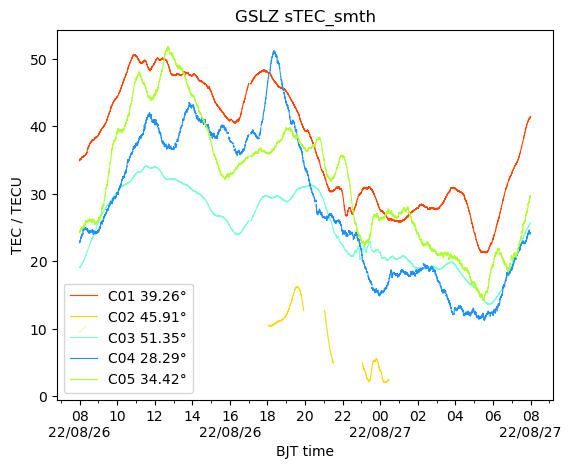

In [16]:
obs = {}

event_date       = datetime.date(2022,9,5).strftime('%Y_%m_%d')
epicenter        = 'Luding'

obs['date'     ] = datetime.date(2022,8,26)

obs['year']      = obs['date'].strftime('%y')
obs['doy']       = obs['date'].strftime('%j')
obs['samp_rate'] = '01s'

# src_dir  = Path(f"/run/media/echoo/TOSHIBA EXT")
src_dir  = Path(f'/run/media/echoo/TOSHIBA EXT/GNSS/{event_date}_{epicenter}')
TEC_dir  = src_dir/obs['doy']/'TEC'
TEC_file = f"TEC_{obs['doy']}_{obs['samp_rate']}_{obs['year']}.nc"
TEC_path = TEC_dir/TEC_file

nc = xr.open_dataset(TEC_path)
nc.coords['time'] = nc.time + np.timedelta64(8, 'h')
nc.attrs['time_sysm'] = 'BJT'

plot_TECs_at_station(nc.sTEC_smth.sel(observer = 'GSLZ'),
                     nc.zenith.sel(observer = 'GSLZ'),
                     nc.time_sysm
                    )             # test

In [18]:
obs['doy']

'238'

In [4]:
sTEC   = nc.sTEC_smth.sel(observer = 'GSLZ', sv = 'C01').dropna(dim = 'time') 
zenith = nc.zenith.sel(observer = 'GSLZ', sv = 'C01')
vTEC   = sTEC * np.cos(zenith)

In [5]:
# Data = {}
# # for var in nc.variables.keys():
# #     Data[var] = nc.variables[var][:]
# #     print(var, Data[var].shape)


# # zenShp       = Data['zenith'].shape
# zenith       = nc['zenith'].sel(observer='AHBB',sv = 'C01')
# Data['sTEC'] = nc['sTEC_smth'].sel(observer='AHBB',sv = 'C01')
# Data['sTEC'] = Data['sTEC'].interpolate_na(dim = 'time',method = 'cubic')
# Data['vTEC'] = Data['sTEC'] * zenith

In [6]:
data         = vTEC
time         = vTEC.time
t            = np.arange(1,len(time)+1,1)

p            = np.polyfit(t, data, 1)
data_trend   = np.polyval(p, t)
data_notrend = data - data_trend

std          = data.std()
variance     = std ** 2
variance     = variance.values

data_norm    = data_notrend / std

In [7]:
# # wavelet = 'cmor4.0-1.0'
# # drelation = 2.32
# # wavelet = 'cmor0.25-2.25'
wavelet = 'cmor1200-0.000075'
# wavelet = 'cmor1.5-1'
# # wavelet = 'cgau8'
# drelation = 2.32
# # wavelet = 'mexh'
# # drelation = 1.43


# L = len(data)

# # N = 0.5*np.power(10, np.floor(np.log10(period)))
# maxscale = np.log2(L*dt/2.0)
# minscale = np.log2(2*dt)+2

# # j = 7/0.02
# # o_scales = 0.5*2**(np.arange(90,j+40)*0.02)

# # o_scales = np.power(2, np.arange(minscale,maxscale, 0.025))
# o_scales = 2**(np.arange(11,13,0.01))
# o_frqcs = np.power(o_scales, -1)
# scales = pywt.frequency2scale(wavelet, o_frqcs)

In [8]:
fc              = 2**(-9)
fband           = 2**(6)
# wavelet         = f'cmor{fband}-{fc}'
wavelet         = 'cgau8'
drelation       = 2.32

sampling_period = 1.0 / 15 / 60            # units: 15min
sampling_rate   = 1.0 / sampling_period    # units: 1/15min
totalfreqc      = 256

# fc              = pywt.central_frequency(wavelet)
# cparam          = 2 * fc * totalscale
# scales          = cparam / np.arange(totalscale, 0, -1)
max_power       = -11
min_power       = -13

interval        = (max_power - min_power) / totalfreqc 
fourier_freqces = 2 ** np.arange(min_power, max_power, interval) 
scales          = pywt.frequency2scale(wavelet, fourier_freqces)

[cwtmatr, frequencies] = pywt.cwt(data_norm, 
                                  scales, 
                                  wavelet, 
                                  1.0, 
                                  'fft'
                                 )

periods = np.power(frequencies, -1)

In [9]:
L = len(data_norm)
coi_scale = scales[-1]-abs(t-L/2.0)+ scales[0]
coimatr = np.zeros(shape = cwtmatr.shape)

for n in range(coimatr.shape[0]):
    scale = scales[n]
    t1 = np.floor(scale*np.sqrt(2.0))
    t2 = np.ceil(L - scale*np.sqrt(2.0))
    coimatr[n][int(t1):int(t2)] = np.nan 
#     cwtmatr[n][:int(t1)] = np.nan
#     cwtmatr[n][int(t2):] = np.nan
    

In [ ]:
fig = plt.figure(figsize=(15,15))
f_ax1 = fig.add_axes([0.1, 0.75, 0.65, 0.2])
f_ax1.plot(time, data)
f_ax1.set_xlabel('BJT time')
f_ax1.set_ylabel('vTEC (TECU)')

f_ax1.set_title(f'a) {data.observer.values} {data.observer.sv.values}')
ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
f_ax1.xaxis.set_major_locator(mdates.HourLocator(ticks))
f_ax1.xaxis.set_minor_locator(mdates.HourLocator())
f_ax1.xaxis.set_major_formatter(format_func)
f_ax1.set_xlim(time[0], time[-1])

f_ax2 = fig.add_axes([0.1, 0.38 ,0.65 ,0.29])
levels = np.arange(0, 20, 1)
cmap = plt.get_cmap('GnBu_r')
cax = add_right_cax(f_ax2, pad = 0.02, width = 0.02)
im = f_ax2.contourf(time, 
                    periods/60/60, 
                    np.abs(cwtmatr), 
                    levels, 
                    cmap = cmap, 
                    alpha = 0.8)

cbar = fig.colorbar(im, cax=cax, extend = 'both')

f_ax2.contourf(time, 
               periods/60/60,
               coimatr, 
               alpha = 0.7, 
               cmap = cmap)
f_ax2.invert_yaxis()
# f_ax2.set_yscale('log', base =2)
f_ax2.set_xlabel(u'BJT time')
f_ax2.set_ylabel('periods (hour)')
f_ax2.set_title('b) VTEC Wavelet Transform')

f_ax2.xaxis.set_major_locator(mdates.HourLocator(ticks))
f_ax2.xaxis.set_minor_locator(mdates.HourLocator())
f_ax2.xaxis.set_major_formatter(format_func)

# f_ax3 = fig.add_axes([0.86, 0.38, 0.18, 0.29])
# f_ax3.plot(power_global, periods)
# # f_ax3.plot(power_global_theory, periods, '--')
# f_ax3.invert_yaxis()
# f_ax3.set_yscale('log', base =2)
# f_ax3.set_xlabel('power')
# f_ax3.set_title('c) Global Wavelet Spectrum')

plt.savefig(f"waveletTransform_"
            f"{obs['date']}_"
            f"{data.observer.values}_{data.observer.sv.values}.png", 
            bbox_inches='tight', 
            dpi = 500
           )
plt.show()

In [ ]:
# L = len(data_norm)
# coi_scale = scales[-1]-abs(t-L/2.0)+ scales[0]
# coimatr = np.zeros(shape = cwtmatr.shape)

# for n in range(coimatr.shape[0]):
#     scale = scales[n]
#     t1 = np.floor(scale*np.sqrt(2.0))
#     t2 = np.ceil(L - scale*np.sqrt(2.0))
#     coimatr[n][int(t1):int(t2)] = np.nan        

In [ ]:
# power_wavelet = np.power(np.abs(cwtmatr), 2)
# power_global  = variance * power_wavelet.sum(axis = 1) / (L-scales)

# alpha         = autocorrelation(data_norm, 2) 
# alpha         = (alpha[0]+np.sqrt(alpha[1]))/2

# power_noise   = (1 - alpha**2) / \
#                 (1 + alpha**2 - 
#                  2 * alpha * np.cos(2 * const.pi * sampling_period * frequencies)
#                 )

# probability   = 0.95
# # dof           = 2*np.sqrt(1 + (L*dt*frequencies / drelation))
# dof = 2

# chi2_critical = chi2.ppf(probability, dof)
# power_wavelet_theory  = variance * power_noise * chi2_critical / dof 

# dof = L-scales
# # dof[dof<1]    = 1
# dof           = 2*np.sqrt(1 + (dof * frequencies / drelation)**2)
# # dof[dof<2]    = 2


# chi2_critical = chi2.ppf(probability, dof)
# power_global_theory = variance * power_noise * chi2_critical / dof
# # dof

In [ ]:
# fig = plt.figure(figsize=(15,15))
# f_ax1 = fig.add_axes([0.1, 0.75, 0.65, 0.2])
# f_ax1.plot(time, data)
# f_ax1.set_xlabel('UT time (s)')
# f_ax1.set_ylabel('STEC (TECU)')
# # f_ax1.set_title('a) HAJY 23/08/14 C01 Wavelet Transform')

# f_ax2 = fig.add_axes([0.1, 0.38 ,0.65 ,0.29])
# # levels = np.arange(0, 1.76, 0.05)
# cmap = plt.get_cmap('GnBu_r')
# cax = add_right_cax(f_ax2, pad = 0.02, width = 0.02)
# im = f_ax2.contourf(time, 
#                     periods, 
#                     np.abs(cwtmatr), 
# #                     levels, 
#                     cmap = cmap, 
#                     alpha = 0.8)
# # f_ax2.contour(time,scales,np.abs(cwtmatr), levels, cmap = cmap, linewidths = 0.05)
# cbar = fig.colorbar(im, cax=cax, extend = 'both')
# # # f_ax2.contourf(time,periods,coimatr, alpha = 0.52, cmap = cmap)
# f_ax2.invert_yaxis()
# f_ax2.set_yscale('log', base =2)
# f_ax2.set_xlabel(u'UT time (s)')
# f_ax2.set_ylabel('periods (s)')
# f_ax2.set_title('b) VTEC Wavelet Power Spectrum (TECU^2)')



# # f_ax3 = fig.add_axes([0.86, 0.38, 0.18, 0.29])
# # f_ax3.plot(power_global, periods)
# # # f_ax3.plot(power_global_theory, periods, '--')
# # f_ax3.invert_yaxis()
# # f_ax3.set_yscale('log', base =2)
# # f_ax3.set_xlabel('power')
# # f_ax3.set_title('c) Global Wavelet Spectrum')

# # plt.savefig('waveletTransform_230814.png', bbox_inches='tight', dpi = 500)
# plt.show()

In [ ]:
# data            = Data['vTEC'].values
# t = data.time

Fs = nc.sample_rate
# Fs = 1/len(data)

# Fre, FFT_y = FFT(Fs, data_norm.values) # for vTEC
Fre, FFT_y = FFT(Fs, data_norm.values)

plt.figure
plt.xscale('log', base =2)
plt.plot(Fre, (abs(FFT_y))**2 )
plt.title(f'{data.observer.values}_{data.observer.sv.values} FFT')
plt.xlabel('periods (hour)')
plt.ylabel('power')

plt.savefig(f'fft_{data.observer.values} {data.observer.sv.values}.png',
            bbox_inches='tight'
           )
plt.show()
